In [1]:
import torch, torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

This notebook is inspired by and based on [this demonstration of VAE in keras](https://github.com/msurtsukov/ae_vae_gan)

In [2]:
%matplotlib inline

In [3]:
from torchsummary import summary
import seaborn as sns
sns.set()

In [4]:
device = torch.device('cuda:0') 
    if torch.cuda.is_available() else torch.device('cpu')

In [5]:
print(device)

cuda:0


In [9]:
# It's dangerous to walk alone. Take these ;)

class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image/image.max()

        return image
    
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape
        
    def forward(self, x):
        return x.view([-1]+list(self.initial_shape))

In [11]:
mnist_transformations = transforms.Compose([
    transforms.ToTensor(),
    Rescale()
#     transforms.Normalize((0.1307,), (0.3081,))
])

In [12]:
BATCH_SIZE = 256
SHUFFLE_DATASET = True
NUM_DATALOADER_WORKERS = 1

In [16]:
data_root = './'

In [19]:
train_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=True,
        transform=mnist_transformations,
        download=True
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DATASET,
    num_workers=NUM_DATALOADER_WORKERS
)

0it [00:00, ?it/s]

9920512it [00:04, 2223337.60it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 81112.54it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:01, 978675.96it/s]                              
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 31623.95it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [20]:
test_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=False,
        transform=mnist_transformations
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS
)

In [22]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, input_shape):
        super().__init__()
        self.register_buffer('_initial_mu', torch.zeros((latent_dim)))
        self.register_buffer('_initial_sigma', torch.ones((latent_dim)))

        self.latent_distribution = torch.distributions.normal.Normal(
            loc=self._initial_mu,
            scale=self._initial_sigma
        )
        input_dim = np.prod(input_shape)
        self.encoder = nn.Sequential(*[
            Flatten(),
            nn.Linear(input_dim, intermediate_dims[0]),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[0], intermediate_dims[1]),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dims[1]),
            nn.Dropout(0.3)
        ])
        
        self.mu_repr = nn.Linear(intermediate_dims[1], latent_dim)# <YOUR CODE HERE>
        self.log_sigma_repr = nn.Linear(intermediate_dims[1], latent_dim)# <YOUR CODE HERE> 
        
        self.decoder = nn.Sequential(*[
            nn.Linear(latent_dim, intermediate_dims[1]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[1]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[1], intermediate_dims[0]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[0], input_dim),
            nn.Sigmoid(),
            RestoreShape(input_shape)
        ])
    
    def _encode(self, x):
        latent_repr = self.encoder(x)
        mu_values = self.mu_repr(latent_repr)
        log_sigma_values = self.log_sigma_repr(latent_repr)
        return mu_values, log_sigma_values, latent_repr
    
    def _reparametrize(self, sample, mu_values, log_sigma_values):
        latent_sample = torch.exp(log_sigma_values) * sample + mu_values# <YOUR CODE HERE>
        return latent_sample

    def forward(self, x, raw_sample=None):
        mu_values, log_sigma_values, latent_repr = self._encode(x)

        if raw_sample is None:
            raw_sample = torch.randn_like(mu_values)

        latent_sample = self._reparametrize(raw_sample, mu_values, log_sigma_values)
        
        reconstructed_repr = self.decoder(latent_sample)
        
        return reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [23]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    fig = plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

#     plt.show()
    return fig


In [24]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

model = VariationalAutoEncoder([256, 128], 2, example_x.shape).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = torch.nn.modules.loss.BCELoss()

reconstructed_repr, latent_sample, mu_values, log_sigma_values = model(example_batch[0][:15].to(device))

summary(model, example_x.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
       BatchNorm1d-4                  [-1, 256]             512
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
       BatchNorm1d-8                  [-1, 128]             256
           Dropout-9                  [-1, 128]               0
           Linear-10                    [-1, 2]             258
           Linear-11                    [-1, 2]             258
           Linear-12                  [-1, 128]             384
        LeakyReLU-13                  [-1, 128]               0
      BatchNorm1d-14                  [

In [25]:
mu_values

tensor([[ 0.2197, -0.2728],
        [ 0.9796, -0.2840],
        [-1.0738, -1.3417],
        [ 0.5138, -1.0202],
        [-0.1448, -1.0202],
        [-0.3847, -0.5531],
        [ 0.6425, -0.0158],
        [ 0.1787,  0.3265],
        [-0.2283,  1.1484],
        [-0.9754,  0.0482],
        [ 0.3642, -0.3497],
        [ 0.1578,  0.7641],
        [ 0.3650,  0.9528],
        [-0.4662, -0.6667],
        [ 0.7216,  0.2157]], device='cuda:0', grad_fn=<AddmmBackward>)

In [26]:
log_sigma_values

tensor([[ 0.2336,  0.4313],
        [ 1.4291, -0.2520],
        [ 0.2739,  0.0622],
        [ 0.0740,  0.0031],
        [ 1.3567, -0.8780],
        [-0.2525,  0.3506],
        [ 0.1124, -0.1684],
        [-0.7726,  0.0317],
        [-0.4093,  2.2094],
        [ 1.0486,  0.4022],
        [ 0.4296, -0.3137],
        [-0.6840,  0.6836],
        [-0.7302,  0.7200],
        [ 0.0657,  0.0734],
        [-0.2845,  0.5475]], device='cuda:0', grad_fn=<AddmmBackward>)

In [29]:
kl_loss = 0.5 * torch.mean(torch.sum(
    mu_values.pow(2) + torch.exp(log_sigma_values) - 1. - log_sigma_values,
    dim=1
))# <YOUR CODE HERE>
kl_loss

tensor(0.8453, device='cuda:0', grad_fn=<MulBackward0>)

In [30]:
test_batch = next(iter(test_loader))

In [31]:
def get_test_predictions(model, test_loader):
    model.eval()
    reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list = [], [], [], []
    for test_batch in tqdm.tqdm_notebook(test_loader, leave=False):
        out = model(test_batch[0].to(device))
        reconstructed_repr, latent_sample, mu_values, log_sigma_values = [x.detach().cpu() for x in out]
        reconstructed_repr_list.append(reconstructed_repr)
        latent_samples_list.append(latent_sample)
        mu_values_list.append(mu_values)
        log_sigma_values_list.append(log_sigma_values)
    return [
        torch.cat(_list, dim=0)
        for _list in [reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list]
    ]

In [32]:
reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)

In [33]:
n = 15 # to generate image with 15x15 examples
digit_size = 28
latent_dim = 2
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model, show=True):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])
            
            z_torch = torch.from_numpy(z_sample).type(torch.FloatTensor).to(device)
            
            x_decoded = model.decoder(z_torch).detach().cpu().numpy()
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys_r')
#         plt.grid(None)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        plt.show()
    return figure

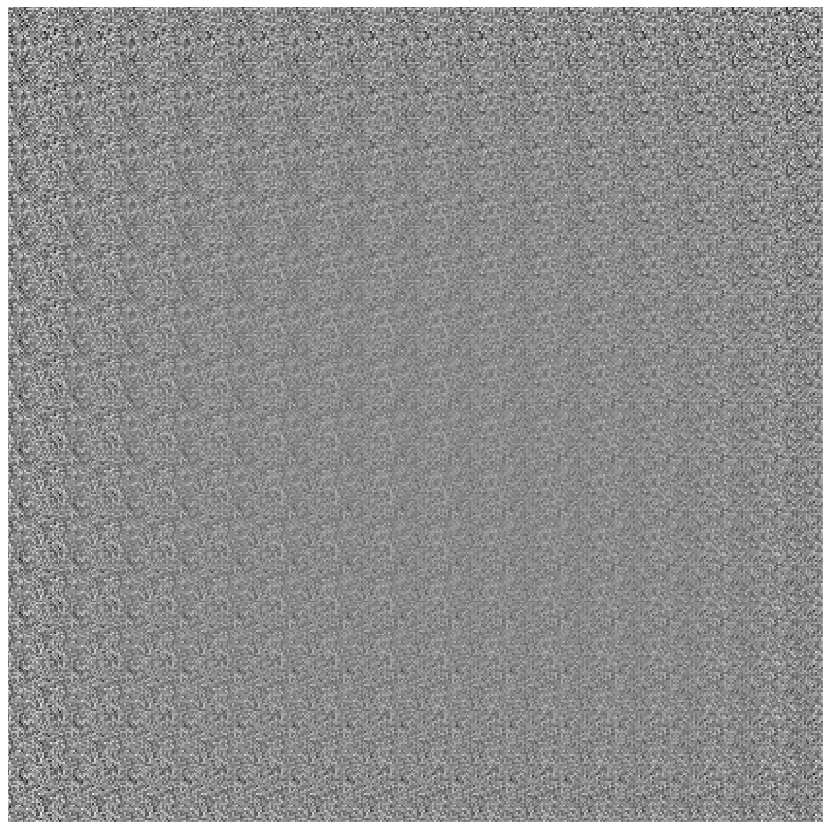

In [35]:
model.eval()
_img = draw_manifold(model, True)

In [36]:
def on_epoch_end(epoch):
    # Saving manifold and z distribution to build plots and animation afterwards
    figure = draw_manifold(model, show=False)
    reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)
    return figure, reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [38]:
def train(num_epochs):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.tnrange(num_epochs):
        model.train()
        loss_accumulator = 0.
        bce_acc = 0.
        kl_acc = 0.
        for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
            batch_x = batch_x.to(device)
            predictions, latent, mu_values, log_sigma_values = model(batch_x)

            kl_loss = 0.5 * torch.mean(torch.sum(
                mu_values.pow(2) + torch.exp(log_sigma_values) - 1. - log_sigma_values,
                dim=1
            ))
            bce_loss = 28*28*loss_func(predictions, batch_x)
            loss = (bce_loss + kl_loss)/2./28./28.
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss/(len(train_loader.dataset))
            bce_acc += bce_loss/(len(train_loader.dataset))
            kl_acc += kl_loss/(len(train_loader.dataset))

        if epoch_num % 5 == 0:
            print('Epoch num: {}\nTraining loss={:.4f}, KL divergence={:.4f}, BCE Loss={:.4f}'.format(
                epoch_num,
                loss_accumulator,
                kl_acc,
                bce_acc
            ))
            model.eval()
            figure, reconstructed_repr_test, latent_sample_test, mu_values_test, log_sigma_values_test = on_epoch_end(epoch_num)
            epochs.append(epoch_num)
            figs.append(figure)
            latent_distrs.append((mu_values_test, log_sigma_values_test))
    return epochs, figs, latent_distrs

In [39]:
epochs, figs, latent_distrs = train(50)

Epoch num: 0
Training loss=0.0014, KL divergence=0.0074, BCE Loss=2.1583


Epoch num: 5
Training loss=0.0006, KL divergence=0.0091, BCE Loss=0.8588


Epoch num: 10
Training loss=0.0005, KL divergence=0.0116, BCE Loss=0.7131


Epoch num: 15
Training loss=0.0004, KL divergence=0.0111, BCE Loss=0.6648


Epoch num: 20
Training loss=0.0004, KL divergence=0.0112, BCE Loss=0.6470


Epoch num: 25
Training loss=0.0004, KL divergence=0.0114, BCE Loss=0.6354


Epoch num: 30
Training loss=0.0004, KL divergence=0.0116, BCE Loss=0.6271


Epoch num: 35
Training loss=0.0004, KL divergence=0.0117, BCE Loss=0.6215


Epoch num: 40
Training loss=0.0004, KL divergence=0.0118, BCE Loss=0.6158


Epoch num: 45
Training loss=0.0004, KL divergence=0.0120, BCE Loss=0.6116


In [40]:
test_labels = []
for b in test_loader:
    test_labels.append(b[1])
test_labels = torch.cat(test_labels, dim=0).numpy()

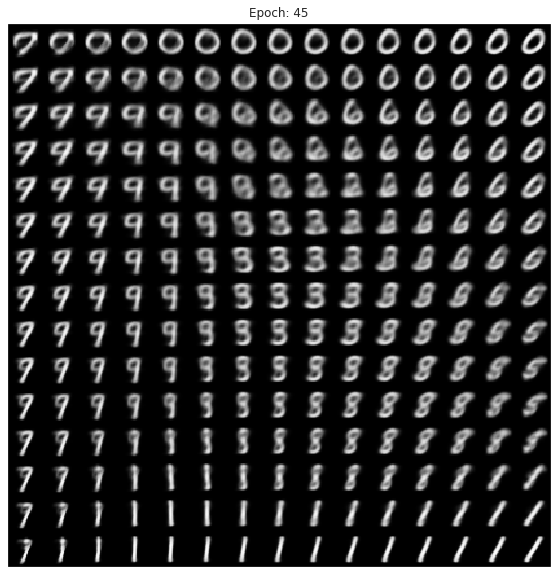

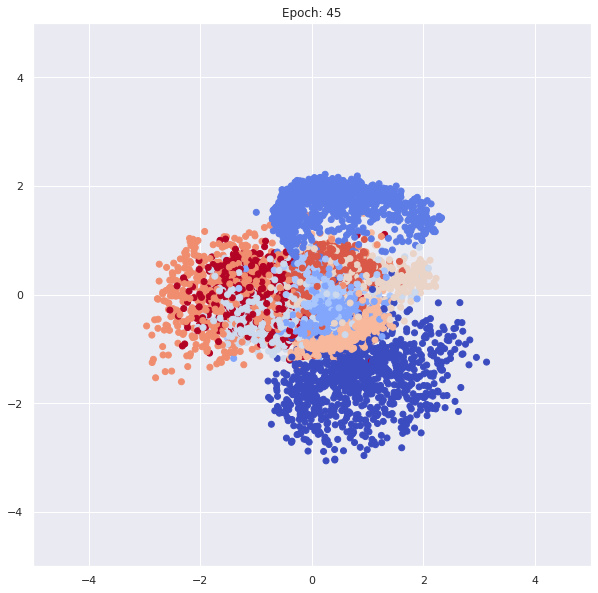

In [41]:
import os
os.makedirs('my_figs', exist_ok=True)

from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, epochs, fname, fig): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28,28)), cmap='Greys_r', norm=norm)
    plt.grid(None)
    plt.title("Epoch: " + str(epochs[0]))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, dpi=80, writer='imagemagick')

def make_2d_scatter_gif(zs, epochs, c, fname, fig):
    im = plt.scatter(zs[0][:, 0], zs[0][:, 1], c=c, cmap=cm.coolwarm)
    plt.colorbar()
    plt.title("Epoch: " + str(epochs[0]))
    def update(i):
        fig.clear()
        im = plt.scatter(zs[i][:, 0], zs[i][:, 1], c=c, cmap=cm.coolwarm)
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(zs)), interval=150)
    anim.save(fname, dpi=80, writer='imagemagick')
    
make_2d_figs_gif(figs, epochs, "./my_figs/manifold2.gif", plt.figure(figsize=(10,10)))
make_2d_scatter_gif([x[0].numpy() for x in latent_distrs], epochs, test_labels, "./my_figs/z_distr2.gif", plt.figure(figsize=(10,10)))

You can find your brand gifs in `./my_figs/` directory ;)

Your home assignment will be to implement conditional VAE (and make in convolutional) and optionally implement GAN. 